In [2]:
import numpy as np
import math
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import *
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
sim = Aer.get_backend('qasm_simulator')
mpl.style.use('Solarize_Light2')

In [3]:
def superDense(s):
    s = s[::-1]
    n = len(s)
    if n<2:
        return None
    qc = QuantumCircuit(n)
    qc.h(0)
    qc.cx(range(n-1),range(1,n))
    for i in range(0,n-1):
        s1 = s[i+1]+s[0]
        if s1=='00':
            qc.i(i)
        if s1=='01':
            qc.x(i)
        if s1=='10':
            qc.z(i)
        if s1=='11':
            qc.z(i)
            qc.x(i)
    qc.cx(range(n-2,-1,-1),range(n-1,0,-1))
    qc.h(0)
    qc.measure_all()
    return qc

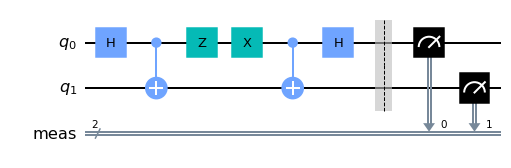

In [4]:
qc = superDense("11")
qc.draw('mpl')

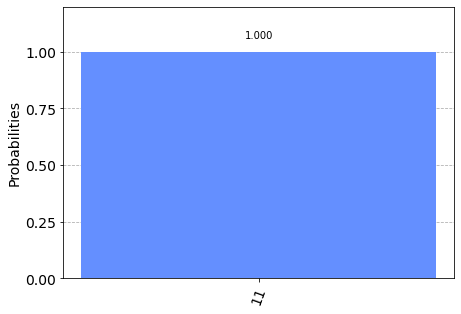

In [5]:
plot_histogram(
    execute(qc,sim,shots=1024).result().get_counts()
)

In [9]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2
                                       and not x.configuration().simulator 
                                       and x.status().operational==True and x.name()!='ibmq_bogota'))
print("least busy backend: ", backend)

least busy backend:  ibmq_belem


Job Status: job has successfully run


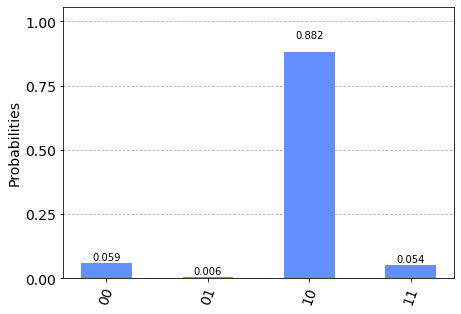

In [10]:
job = execute(qc,backend=backend,shots=1024)
job_monitor(job)
plot_histogram(
    job.result().get_counts()
)

In [11]:
cal_cir, state_label = complete_meas_cal(qr=qc.qregs[0],circlabel = 'mesurement_calculation')
cal_job = execute(cal_cir,backend = backend,shots = 1024,
optimization_level = 0)
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


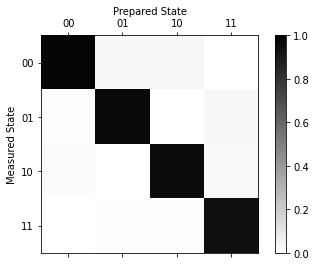

In [12]:
meas_fitter = CompleteMeasFitter(cal_results, state_label)
results = job.result()
meas_fitter.plot_calibration()

In [13]:
mit_res = meas_fitter.filter.apply(results)

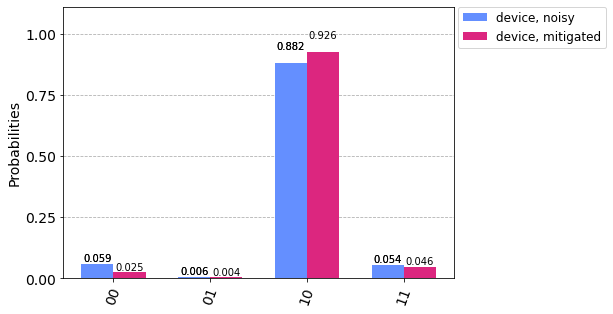

In [14]:
dev_counts = results.get_counts(qc)
mit_counts = mit_res.get_counts(qc)
plot_histogram((dev_counts,mit_counts),legend = ['device, noisy','device, mitigated'])

In [111]:
def tp(arr:tuple)->np.array:
    ar = arr[0]
    for i in arr[1:]:
        ar=np.kron(ar,i)
    return ar

In [113]:
H=1/math.sqrt(2)*np.array([np.array([1,1]),np.array([1,-1])])
CX=np.array([np.array([1,0,0,0]),np.array([0,1,0,0]),np.array([0,0,0,1]),np.array([0,0,1,0])])
X=np.array([np.array([0,1]),np.array([1,0])])
Z=np.array([np.array([1,0]),np.array([0,-1])])
I=np.array([np.array([0,1]),np.array([1,0])])
x=np.array([1,0,0,0,0,0,0,0])

In [114]:
np.matmul(
    tp((X,X,X))
    ,x
)

array([0, 0, 0, 0, 0, 0, 0, 1])